In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from __future__ import  division, print_function

import argparse
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#from nnest.nested import NestedSampler
from scipy.stats import poisson, norm, beta, gamma
from scipy.special import logsumexp

class Ebola(object):

    def __init__(self, N, country, plot=False):
        df = pd.read_csv('data/previous-case-counts-%s.csv' % country)
        df['WHO report date'] = pd.to_datetime(df['WHO report date'], format="%d/%m/%Y")
        df['delta_time_days'] = (df['WHO report date'] - df['WHO report date'].min()).dt.days
        df = df.sort_values('delta_time_days')
        self.df = df
        self.N = N
        self.country = country
        self.plot = plot
        # Differential case counts
        self.delta_cases = df['Total Cases'].values[1:] - df['Total Cases'].values[:-1]
        # Differential death counts
        self.delta_deaths = df['Total Deaths'].values[1:] - df['Total Deaths'].values[:-1]
        print(df)

    def rate(self, y, t, beta, k, tau, sigma, gamma, f):
        S, E, I, R, C, D = y
        beta_t = beta * np.exp(-k * (t - tau))
        dydt = [
            -beta_t * S * I / self.N,
            beta_t * S * I / self.N - sigma * E,
            sigma * E - gamma * I,
            (1 - f) * gamma * I,
            sigma * E,
            f * gamma * I
        ]
        return dydt

    def solve(self, beta, k, tau, sigma, gamma, f, offset):
        y0 = [self.N - 1, 0, 1, 0, 1, 0]
        # Offset initial time by constant
        t = self.df['delta_time_days'].values + offset
        t[t < 0] = 0
        t = np.insert(t, 0, 0, axis=0)
        sol = odeint(self.rate, y0, t, args=(beta, k, tau, sigma, gamma, f))
        if self.plot:
            self.makeplot()
        sol = sol[1:]
        return sol

    def makeplot(self, samples=None, ax=None):
        if samples is not None:
            model_cases = np.zeros((len(samples), len(self.df['delta_time_days'])))
            model_deaths = np.zeros_like(model_cases)
            for i, theta in enumerate(samples):
                # compute ode model solution
                theta_ode = theta[:-4]
                sol = self.solve(*theta_ode)
                model_cases[i] = sol[:, 4]
                model_deaths[i] = sol[:, 5]
            c05, c50, c95 = np.percentile(model_cases, [5, 50, 95], axis=0)
            d05, d50, d95 = np.percentile(model_deaths, [5, 50, 95], axis=0)

        if ax is None:
            f, ax = plt.subplots()
        ax.set_title(self.country)
        t = self.df['delta_time_days']
        if samples is not None:
            ax.plot(t, c50, linestyle='solid', marker='None', color='red')
            ax.fill_between(t, c05, c95, color='red', alpha=0.2)
        ax.plot(t, self.df['Total Cases'], color='red', mfc='None', marker='o', linestyle='None')
        if samples is not None:
            ax.plot(t, d50, linestyle='solid', marker='None', color='black')
            ax.fill_between(t, d05, d95, color='blue', alpha=0.2)
        ax.plot(t, self.df['Total Deaths'], color='blue', mfc='None', marker='o', linestyle='None')
        plt.show()
    
    def log_prior(self, theta):
        b, k, tau, sigma, g, f, offset = theta[:-4]
        scatter, scatter_outlier, prob_scatter, prob_outlier = theta[-4:]
        logPs = []
        # individual priors
        logPs.append(beta.logpdf(b, 1.1, 2))
        logPs.append(gamma.logpdf(k, 1.1, 0))
        logPs.append(gamma.logpdf(tau, 5, 0))
        logPs.append(beta.logpdf(sigma, 1.15, 2))
        logPs.append(beta.logpdf(g, 1.15, 2))
        logPs.append(beta.logpdf(f, 2, 2))
        logPs.append(gamma.logpdf(offset, 100, 0))
        logPs.append(gamma.logpdf(scatter, 1.01, 0))
        logPs.append(gamma.logpdf(scatter_outlier, 2, 0))
        logPs.append(beta.logpdf(prob_scatter, 1, 10))
        logPs.append(beta.logpdf(prob_outlier, 1, 100))
        # combined priors
        logPs.append(gamma.logpdf(scatter_outlier/scatter, 100, 1))
        logPs.append(gamma.logpdf(prob_scatter/prob_outlier, 100, 1)) 
        return np.sum(logPs)
    
    def log_like(self, theta):
        logP = self.log_prior(theta)
        if np.isinf(logP):
            return -np.infty
        # compute ode model solution
        theta_ode = theta[:-4]
        sol = self.solve(*theta_ode)
        #sol = sol[1:]
        model_cases = sol[:, 4]
        model_deaths = sol[:, 5]
        delta_model_cases = np.diff(model_cases)
        delta_model_deaths = np.diff(model_deaths)
        np.putmask(delta_model_cases, delta_model_cases <= 0, 1e-9)
        np.putmask(delta_model_deaths, delta_model_deaths <= 0, 1e-9)
        # compute loglike
        scatter, scatter_outlier, prob_scatter, prob_outlier = theta[-4:]
        # avoid NaNs in logarithm
        prob_scatter = np.clip(prob_scatter, 1e-99, 1-1e-99)
        prob_outlier = np.clip(prob_outlier, 1e-99, 1-1e-99)
        scatter = np.clip(scatter, 1e-9, 1e9)
        scatter_outlier = np.clip(scatter_outlier, 1e-9, 1e9)
        # model logL as sum of three distributions
        # 1: an intrinsic Poisson distribution on the true counts
        # 2: a Normal scatter proportional to the true count
        # 3: a Normal outlier distribution, proportional to the true count
        logLs = []
        # for cases
        logLs.append(np.log(1 - prob_outlier - prob_scatter) +
                    poisson.logpmf(self.delta_cases, delta_model_cases))
        logLs.append(np.log(prob_scatter) +
                     norm.logpdf(self.delta_cases, delta_model_cases, delta_model_cases * scatter))
        logLs.append(np.log(prob_outlier) + 
                     norm.logpdf(self.delta_cases, delta_model_cases, delta_model_cases * scatter_outlier))
        # for deaths
        logLs.append(np.log(1 - prob_outlier - prob_scatter) +
                    poisson.logpmf(self.delta_deaths, delta_model_deaths))
        logLs.append(np.log(prob_scatter) +
                     norm.logpdf(self.delta_deaths, delta_model_deaths, delta_model_deaths * scatter))
        logLs.append(np.log(prob_outlier) + 
                     norm.logpdf(self.delta_deaths, delta_model_deaths, delta_model_deaths * scatter_outlier))
        # using logsumexp helps maintain numerical precision
        logL = np.sum(logsumexp(logLs, axis=0))
        if np.isnan(logL):
            return -np.infty
        return logL
        

    def neg_log_posterior(self, theta):
        log_like = self.log_like(theta)
        log_prior = self.log_prior(theta)
        return -(log_prior + log_like)

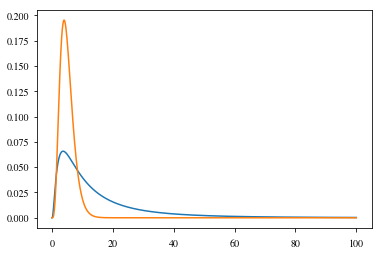

In [5]:
from scipy.stats import poisson, norm, beta, gamma, lognorm
x = np.linspace(0, 100, 1000)
plt.plot(x, lognorm.pdf(x, 1, 0, 10))
plt.plot(x, gamma.pdf(x, 5, 0))

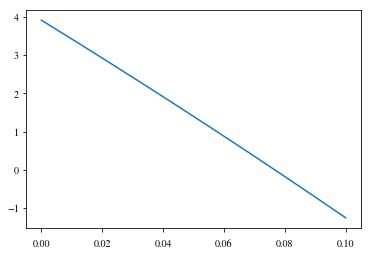

In [78]:
from scipy.stats import poisson, norm, beta, gamma, lognorm
x = np.linspace(0, 0.1, 1000)
plt.plot(x, beta.logpdf(x, 1, 50))

In [3]:
# define some helper functions

def get_samples(sampler, nburn):
    c = sampler.chain
    if c.ndim == 4:
        c = c[0]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))

In [4]:
N = 1000000
country = 'guinea'
e = Ebola(N, country, plot=False)

# set up ptemcee
np.random.seed(666)  # reproducible

par = ('beta', 'k', 'tau', 'sigma', 'gamma', 'f', 'offset',
       'scatter', 'scatter_outlier', 'prob_scatter', 'prob_outlier')
ndim = len(par)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
ntemp = 5  # number of parallel-tempered chains
nburn = 5000  # "burn-in" period to let chains stabilize
nsamp = 10000  # number of MCMC steps to take after burn-in

p0 = np.array([0.3, 0.005, 5, 0.15, 0.15, 0.5, 10, 0.01, 1.0, 0.1, 0.01])
initial_theta = np.random.normal(p0, 0.1 * np.abs(p0), (ntemp, nwalkers, ndim))

     Unnamed: 0 WHO report date  Total Cases  Total Deaths  delta_time_days
264         264      2014-03-25           86            59                0
263         263      2014-03-26           86            60                1
262         262      2014-03-27          103            66                2
261         261      2014-03-31          112            70                6
260         260      2014-04-01          122            80                7
259         259      2014-04-02          127            83                8
258         258      2014-04-07          151            95               13
257         257      2014-04-10          157           101               16
256         256      2014-04-17          197           122               23
255         255      2014-04-21          203           129               27
254         254      2014-04-23          208           136               29
253         253      2014-04-30          221           146               36
252         

In [5]:
from scipy.optimize import minimize

In [7]:
import ptemcee

In [8]:
sampler = ptemcee.Sampler(nwalkers, ndim, e.log_like, e.log_prior, ntemps=ntemp, threads=4)

In [9]:
r = sampler.run_mcmc(initial_theta, nburn+nsamp)

/usr/local/anaconda/envs/py3.6/lib/python3.6/site-packages/ipykernel/__main__.py:131: RuntimeWarning: invalid value encountered in log
/usr/local/anaconda/envs/py3.6/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: invalid value encountered in log


ValueError: Log likelihood function returned NaN.

In [ ]:
import pickle
with open('sampler', 'wb') as f:
    pickle.dump(sampler, f)

In [ ]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,10])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    for w in range(nwalkers):
            plt.plot(numpy.arange(sampler.chain.shape[2]), sampler.chain[2,w,:,i], 'r-', alpha=0.1)
            plt.plot(numpy.arange(sampler.chain.shape[2]), sampler.chain[0,w,:,i], 'g-', alpha=0.1)
    plt.ylabel(p)
    aymin, aymax = plt.ylim()
    plt.vlines(nburn, aymin, aymax, linestyle=':')
    plt.ylim(aymin, aymax)

In [ ]:
# plot the chains to visually assess auto correlation time at equilibrium
plt.figure(figsize=[20,10])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    for w in range(0,nwalkers,10):
            plt.plot(numpy.arange(100), sampler.chain[1,w,nburn:nburn+100,i], 'r-')
            plt.plot(numpy.arange(100), sampler.chain[0,w,nburn:nburn+100,i], 'g-')
    plt.ylabel(p)
    aymin = np.min(sampler.chain[0,:,nburn:,i])
    aymax = np.max(sampler.chain[0,:,nburn:nburn+100,i])
    plt.ylim(aymin, aymax)
    plt.tight_layout()

In [ ]:
samples = get_samples(sampler, nburn)

In [ ]:
# examine parameter histograms
plt.figure(figsize=[20,10])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    n, b, patches = plt.hist(samples[:,i], bins=100, color='b', histtype='stepfilled', log=True)
    plt.xlabel(p)
    plt.tight_layout()

In [ ]:
import corner
# create mega plot for parallel-tempered method
corner.corner(samples, labels=par)
ax = plt.subplot(2, 2, 2)
selection = np.random.choice(len(samples), 1000, replace=False)
e.makeplot(samples=samples[selection], ax=ax)
plt.subplots_adjust(wspace=0.15, hspace=0.15);

In [ ]:
e.makeplot(samples=[])